## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize

import warnings
warnings.filterwarnings('ignore')

## 1. Data Options

In [3]:
run_data = 'era5'
variable = 'PRCP'
general_path = 'data'
start_utc = 0
end_utc = 24

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

## 2. Open Data

In [4]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')
dt_daily = dt.sum(dim='time')

## 3. Find Ensemble Member Averages

### 3.1 Define Members

In [6]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

### 3.2 Ensemble Mean For Urban and Nourban

In [131]:
crsn = 20
dt_urban_ens = dt_daily.sel(ens=urban_members).mean(dim='ens').coarsen(south_north=crsn, west_east=crsn).mean()
dt_nourban_ens = dt_daily.sel(ens=nourban_members).mean(dim='ens').coarsen(south_north=crsn, west_east=crsn).mean()

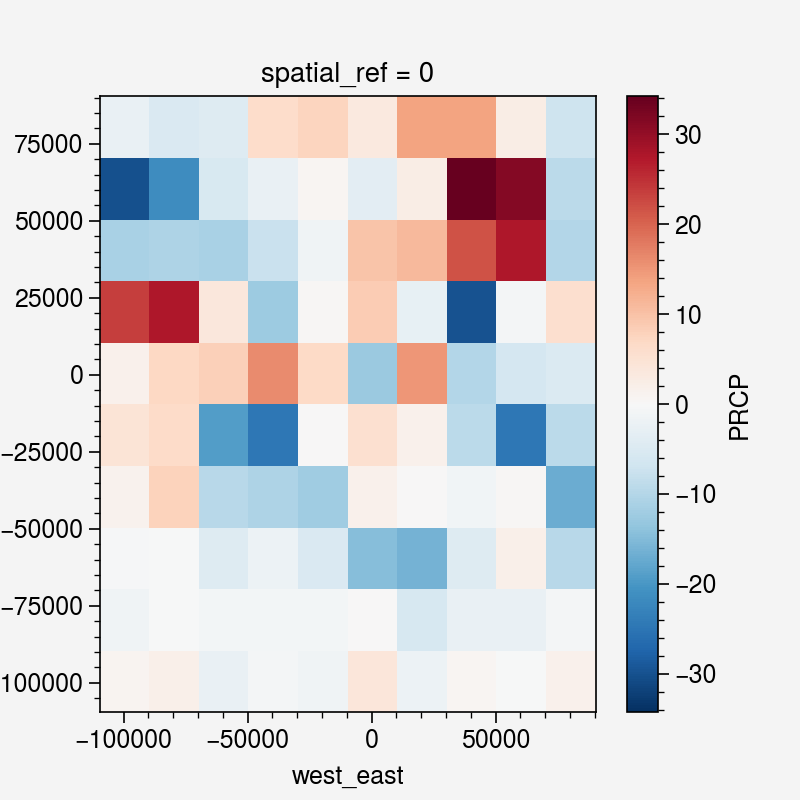

In [132]:
(dt_urban_ens - dt_nourban_ens).plot()

### 3.3 Urban and Nourban Daily Total

In [133]:
dt_daily_urban = dt_daily.sel(ens=urban_members).coarsen(south_north=crsn, west_east=crsn).mean()
dt_daily_nourban = dt_daily.sel(ens=nourban_members).coarsen(south_north=crsn, west_east=crsn).mean()

## 4. Visualization

### 4.1 Open Land Use Datasets

In [134]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

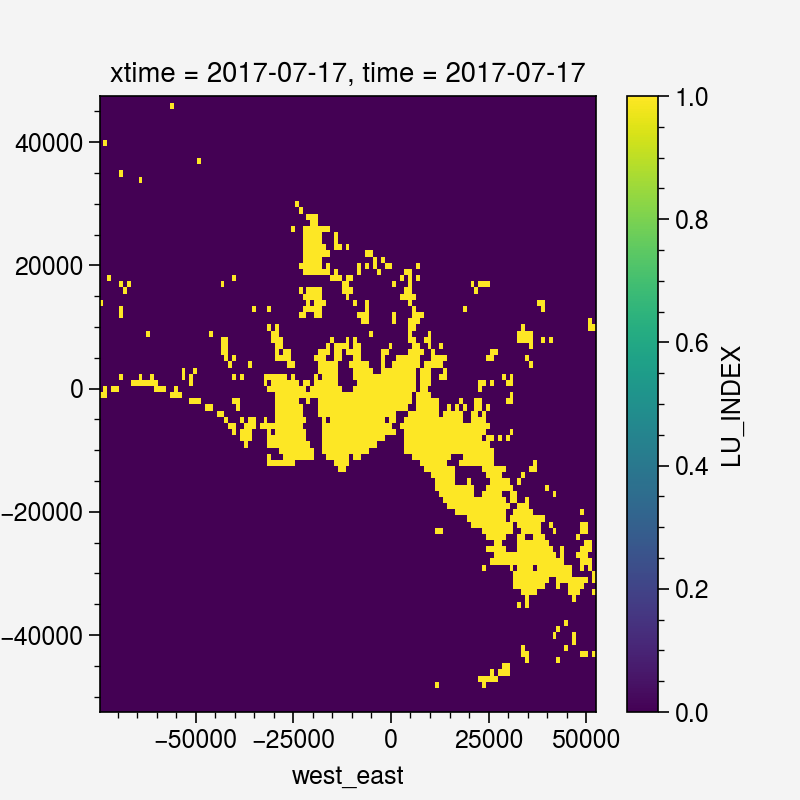

In [135]:
urban_luse_border.plot()

### 4.2 Parameters

In [136]:
# cmap for total urban and nourban hourly precipitation
nws_precip_colors_total = [
    "#FFFFFF",
    "#a9dff9",
    "#8acef5",
    "#67aae1", 
    "#4aa77a", 
    "#a2cf5a", 
    "#fed755", 
    "#f29a3e", 
    "#ef6934",
    "#cf212a",
    "#620878",
    
]
cmap = ListedColormap(nws_precip_colors_total)

In [137]:
# Parameters to change (plot) -------------------
# projection
proj = dt.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2],
             [3, 4],
             [5, 6],
             [7, 8],
            ]
graphic_no = 8

# graphic vmin, vmax and norms
clevs_total = [0, 12, 24, 36, 60, 84, 120, 156, 200, 250, 300, 350]
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = clevs_total

### 4.3 Plot Original

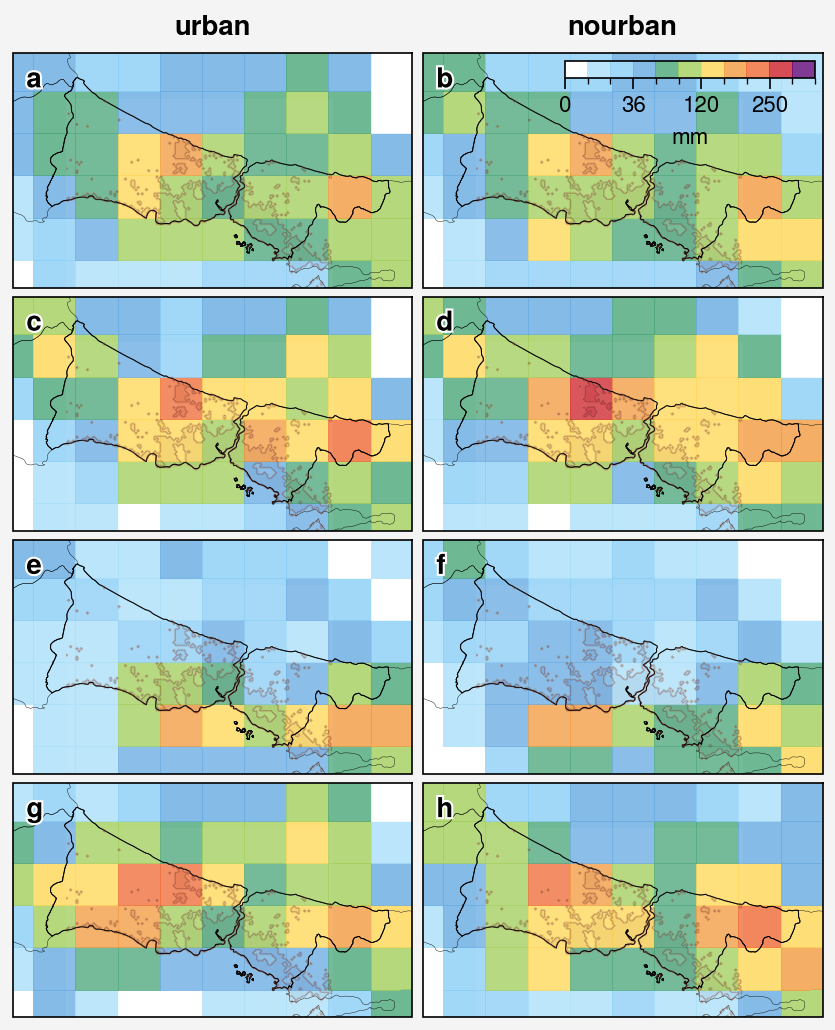

In [89]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.4,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['urban', 'nourban'],
           #collabels=['08UTC', '09UTC', '10UTC', '11UTC']
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)


for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    
dt_border = urban_luse_border

# ensemble mean
mesh = axs[0].pcolormesh(dt_urban_ens['lon'], 
                            dt_urban_ens['lat'],
                            dt_urban_ens, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
mesh = axs[1].pcolormesh(dt_nourban_ens['lon'], 
                            dt_nourban_ens['lat'],
                            dt_nourban_ens, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)

# urban ensemble members
for i, t in enumerate([2,4,6]):
        
    mesh = axs[t].pcolormesh(dt_daily_urban[i]['lon'], 
                        dt_daily_urban[i]['lat'],
                        dt_daily_urban[i], 
                        cmap = cmap,
                        norm=norm,
                        zorder = 0.2,
                        alpha=0.8)
    
# nourban ensemble members
for i, t in enumerate([3, 5, 7]):
        
    mesh = axs[t].pcolormesh(dt_daily_nourban[i]['lon'], 
                        dt_daily_nourban[i]['lat'],
                        dt_daily_nourban[i], 
                        cmap = cmap,
                        norm=norm,
                        zorder = 0.2,
                        alpha=0.8)

# urban borders
for t in range(graphic_no):
    
    contour = axs[t].contourf(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            lw = 0.1,
                            alpha = 0.05,
                            
                            )

# colorbars
axs[1].colorbar(mesh,
                 label='mm',
                 ticks = ticks,
                 loc='ur', length=10,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.3
                )

#save figure
#plt.savefig(r'pictures/era5_ENS_precipitation_hourly.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

### 4.3 Plot Difference

In [138]:
# graphic vmin, vmax and norms
cmap = proplot.Colormap('ColdHot')
clevs_total = np.arange(-100, 100.1, 10)
ticks = np.arange(-100, 100.1, 50)

norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)

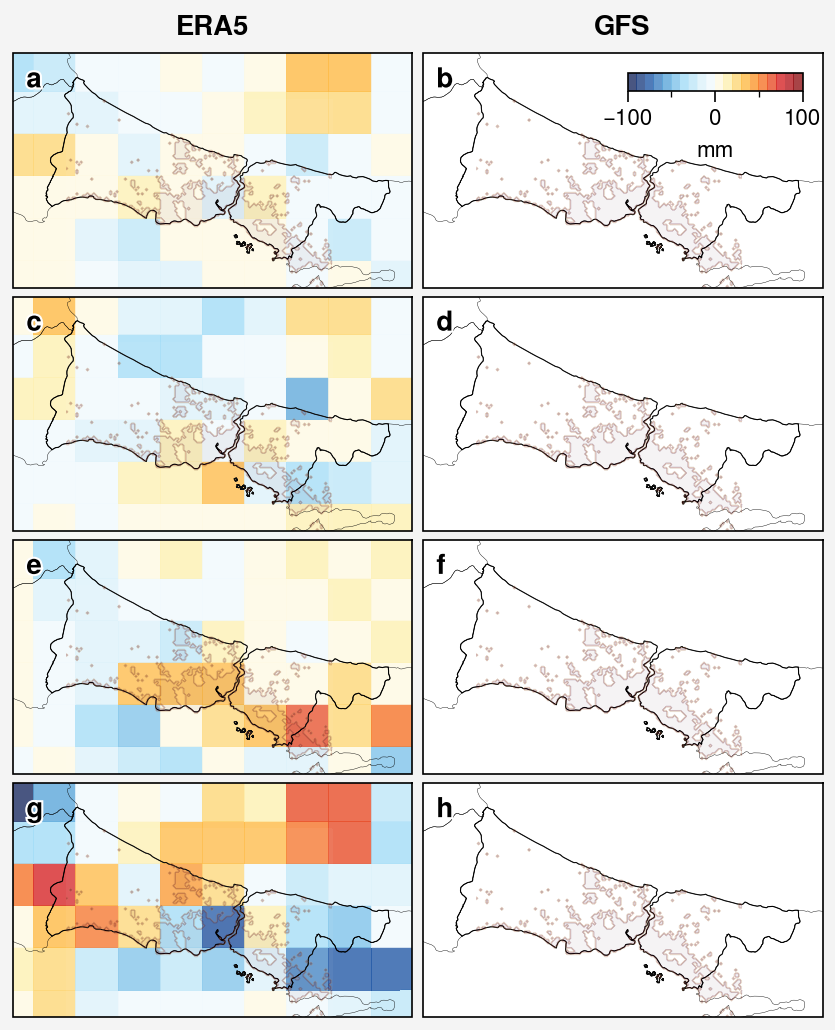

In [139]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.4,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['ERA5', 'GFS'],
           #collabels=['08UTC', '09UTC', '10UTC', '11UTC']
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)


for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    
dt_border = urban_luse_border

# ensemble mean
# era5
mesh = axs[0].pcolormesh(dt_urban_ens['lon'], 
                            dt_urban_ens['lat'],
                            dt_urban_ens-dt_nourban_ens, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)

# LIN 
# era5
mesh = axs[2].pcolormesh(dt_daily_urban['lon'], 
                            dt_daily_urban['lat'],
                            dt_daily_urban[0]-dt_daily_nourban[0], 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)

# THOMPSON 
# era5
mesh = axs[4].pcolormesh(dt_daily_urban['lon'], 
                            dt_daily_urban['lat'],
                            dt_daily_urban[1]-dt_daily_nourban[1], 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)

# WSM6 
# era5
mesh = axs[6].pcolormesh(dt_daily_urban['lon'], 
                            dt_daily_urban['lat'],
                            dt_daily_urban[2]-dt_daily_nourban[2], 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)

# urban borders
for t in range(graphic_no):
    
    contour = axs[t].contourf(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            lw = 0.1,
                            alpha = 0.05,
                            
                            )

# colorbars
axs[1].colorbar(mesh,
                 label='mm',
                 ticks = ticks,
                 loc='ur', length=7,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                 pad = 0.8
                )

#save figure
#plt.savefig(r'pictures/era5_ENS_precipitation_hourly.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

## 5. Precipitation Difference Within Urban Boundaries

### 5.1 Vectorize Tiff Data

urban_luse_border = urban_luse_border.rio.set_spatial_dims(x_dim='west_east', y_dim='south_north')
urban_luse_border.rio.to_raster('data/lu_index/urban_luse_border_raster.tiff')

In [174]:
gg = rioxarray.open_rasterio('data/lu_index/urban_luse_border_raster.tiff').squeeze('band', drop=True)

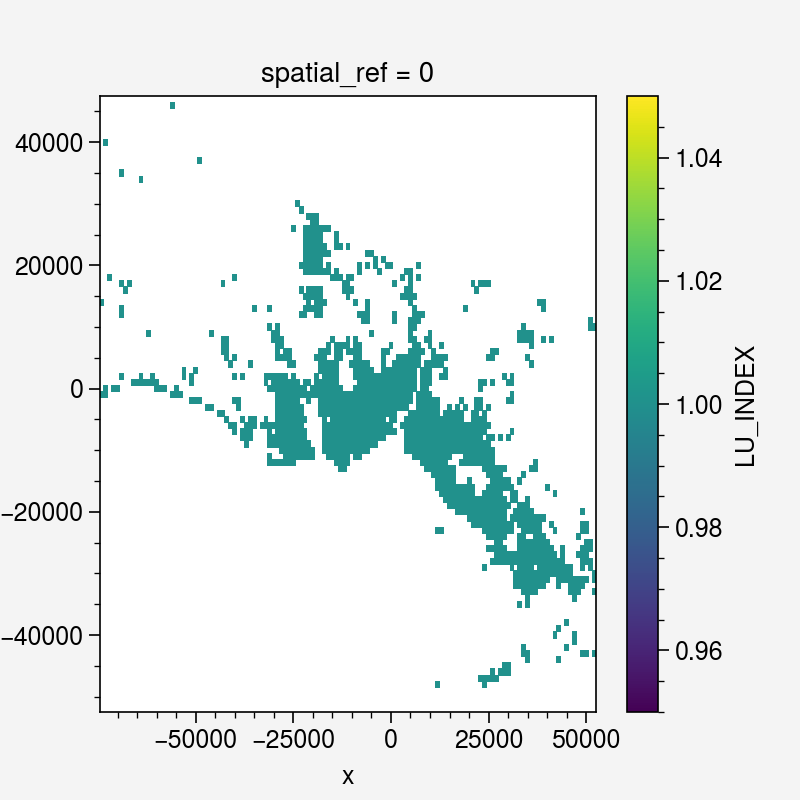

In [175]:
gg.plot()

In [176]:
gg = gg.rio.write_crs(dt.rio.crs)
gdf = xr_vectorize(gg,
                   crs=gg.rio.crs,
                   mask=gg.values==1)

<AxesSubplot:>

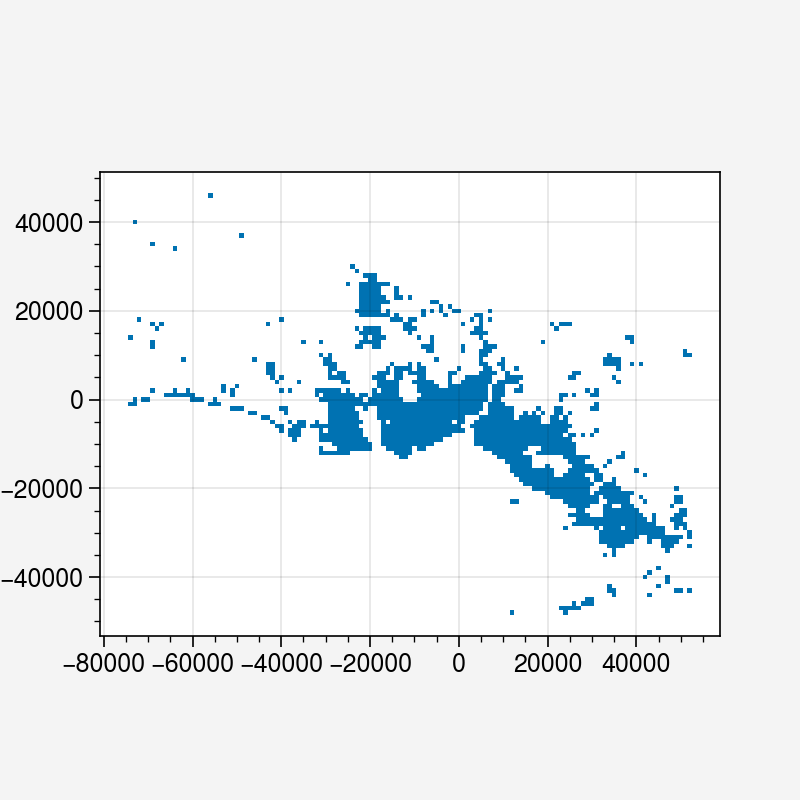

In [177]:
gdf.plot()

### 5.2 Clip WRF Data to Shapefile

In [178]:
def clip_to_city(data, shapefile, crs_data, x_dims, y_dims):
    
    data= data.rio.set_spatial_dims(x_dim=x_dims, y_dim=y_dims)

    data = data.rio.write_crs(crs_data)
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [179]:
x_dims = 'west_east'
y_dims = 'south_north'

dt_urban_ens_clip = clip_to_city(dt_urban_ens, gdf, 
                                 dt_urban_ens.rio.crs, 
                                 x_dims,
                                 y_dims)

dt_nourban_ens_clip = clip_to_city(dt_nourban_ens, gdf, 
                                 dt_nourban_ens.rio.crs, 
                                 x_dims,
                                 y_dims)

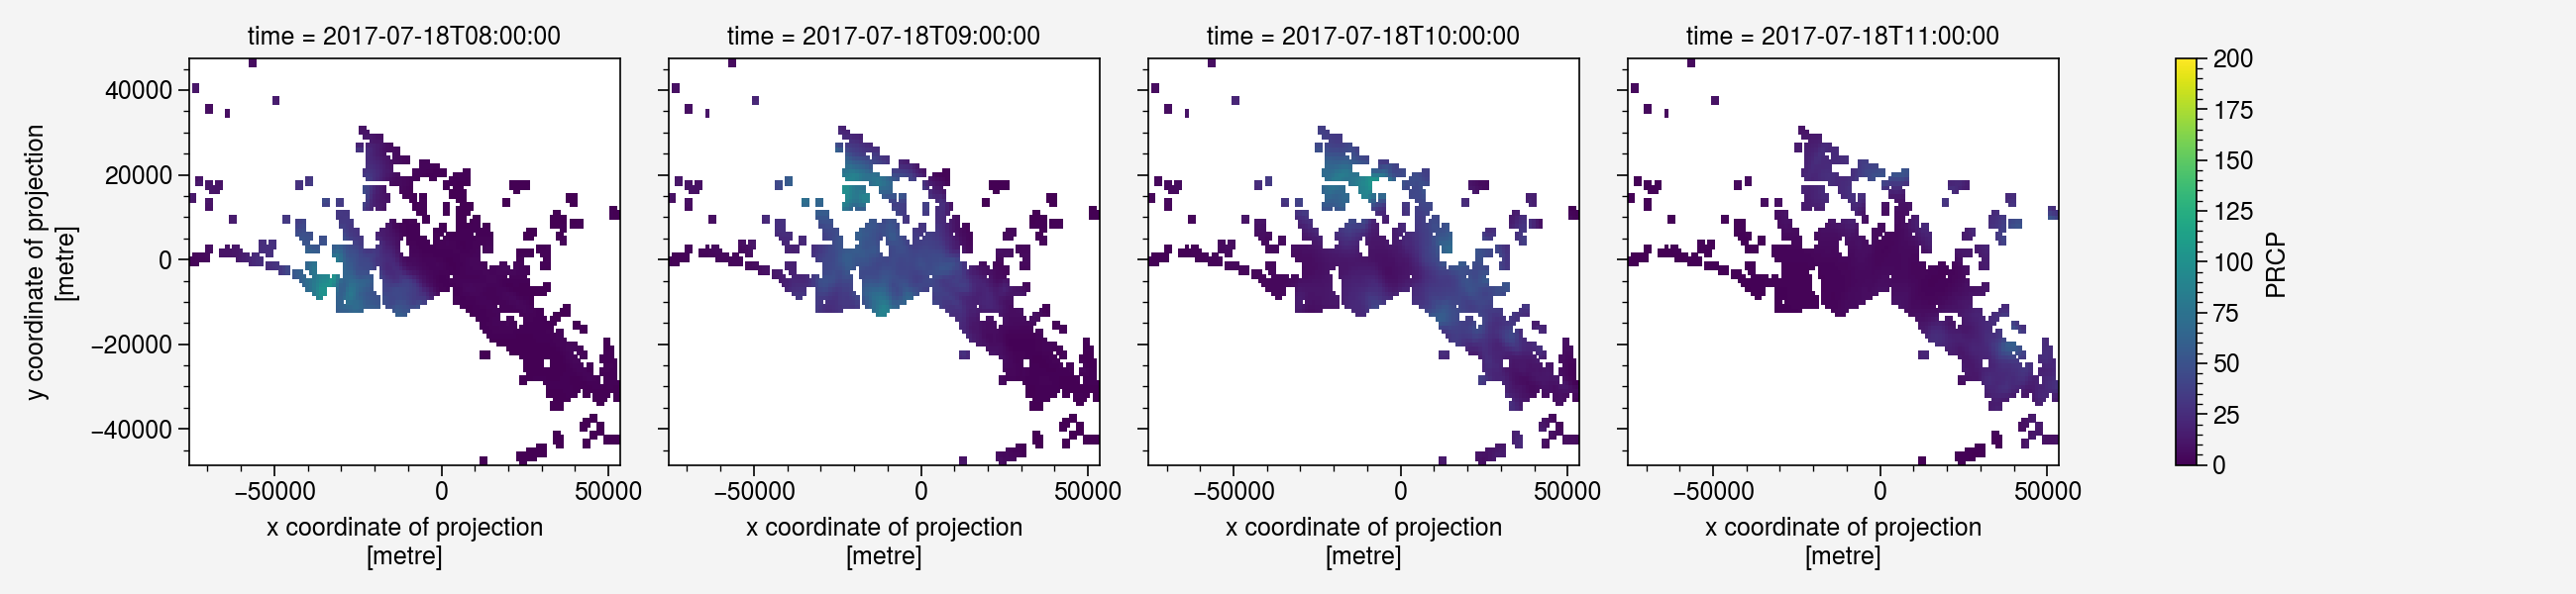

In [180]:
dt_urban_ens_clip.plot(col='time', vmin=0, vmax=200)

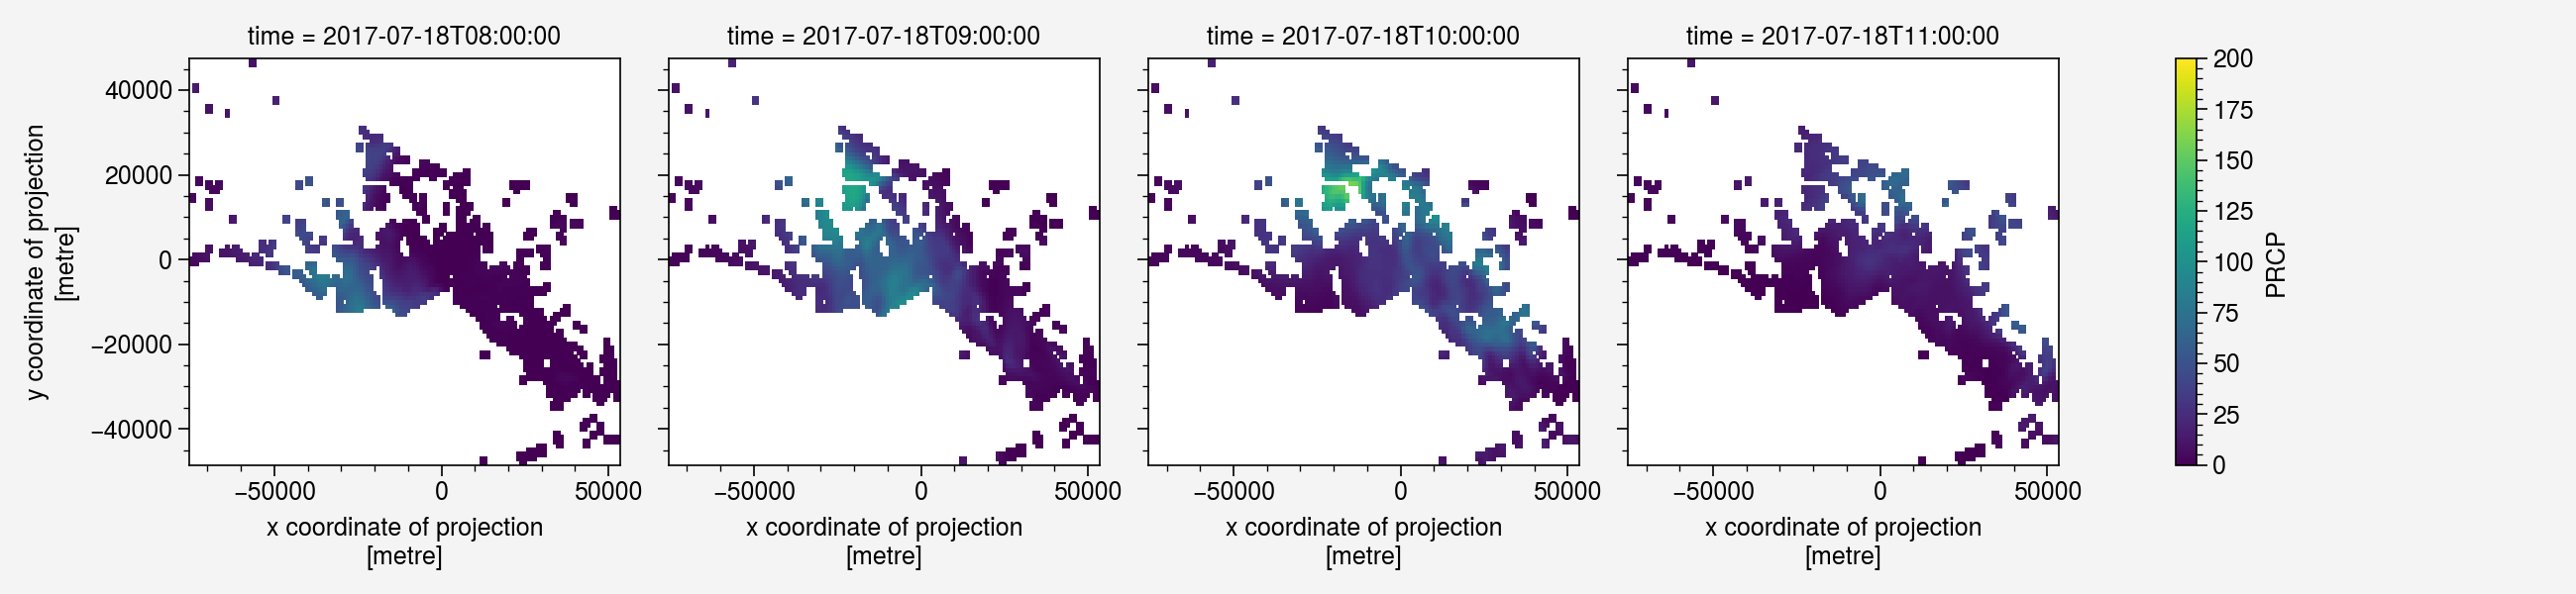

In [181]:
dt_nourban_ens_clip.plot(col='time', vmin=0, vmax=200)

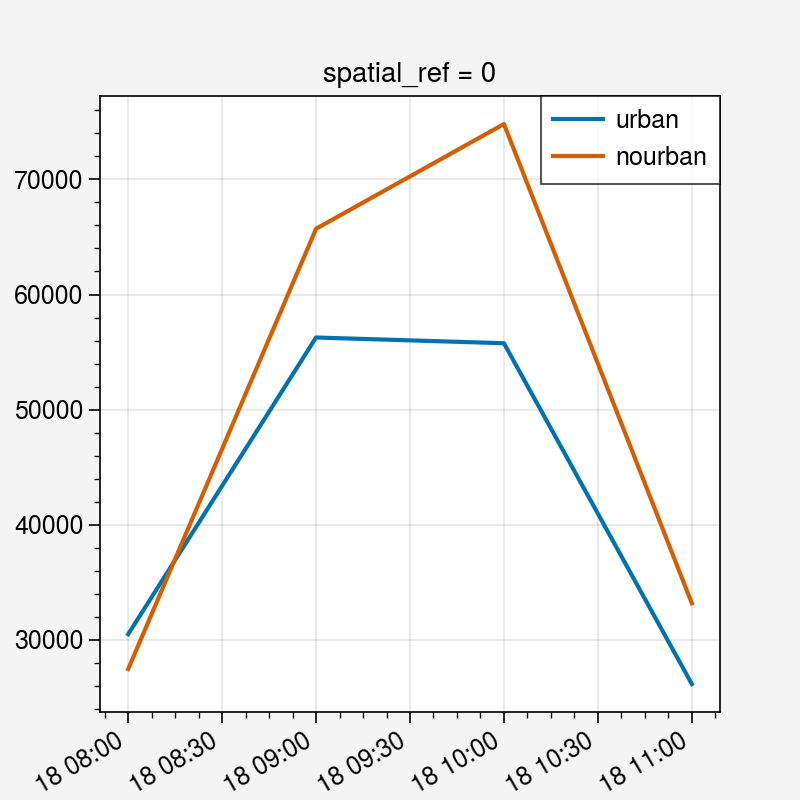

In [182]:
dt_urban_ens_clip.sum(dim=[x_dims, y_dims],).plot(label = 'urban')
dt_nourban_ens_clip.sum(dim=[x_dims, y_dims],).plot(label = 'nourban')
plt.legend()

In [183]:
print(dt_urban_ens_clip.sum().compute())
print(dt_nourban_ens_clip.sum().compute())

<xarray.DataArray 'PRCP' ()>
array(168708.7, dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray 'PRCP' ()>
array(201181.53, dtype=float32)
Coordinates:
    spatial_ref  int64 0


In [184]:
urban_grid_total = dt_urban_ens_clip.sum().compute().values
nourban_grid_total = dt_nourban_ens_clip.sum().compute().values

In [185]:
# percentage difference for the 4 hour period
(urban_grid_total-nourban_grid_total)/urban_grid_total*100

-19.247867166996002